In [1]:
cd /home

/home


In [2]:
import tensorflow as tf
import pandas as pd 

import matplotlib.pyplot as plt

import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2

from src.data.loaders import load_data

2023-07-24 12:03:03.803150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 12:03:03.925344: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## RECORDS

In [5]:
off_nsp = True
data = load_data('./data/records/macho_clean/test/',
                    batch_size=10,
                    window_size=50,
                    sampling=True,
                    nsp_prob=.5,
                    test_mode=True,
                    off_nsp=off_nsp)

[INFO] Sampling random windows


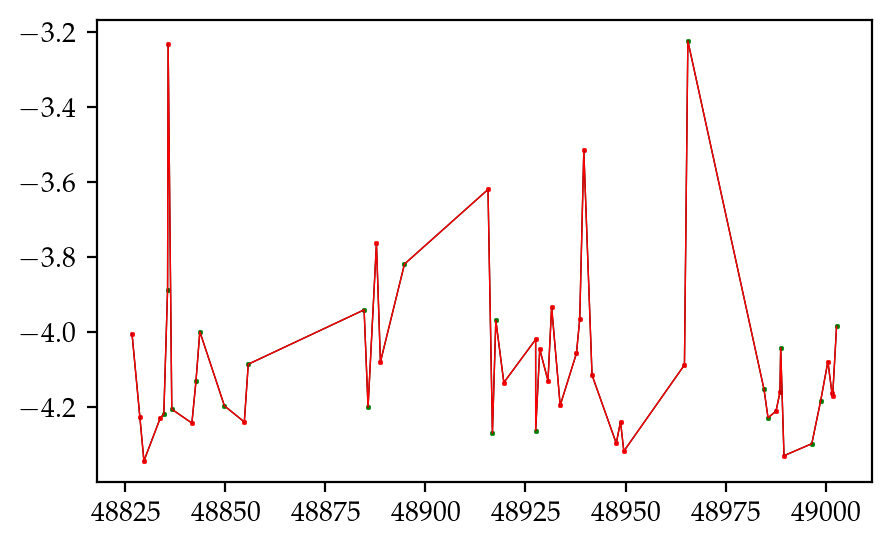

In [6]:
import numpy as np
plt.figure(figsize=(5, 3), dpi=200)
for x, y in data.take(1):
    
    N =1
    start = 0 if off_nsp else 1
    original   = x['original'][N]
    mask       = x['mask'][N]
    magnitudes = x['magnitudes'][N, start:, 0]
    target_magn = y['magnitudes'][N, :, 0]
    att_mask   = x['att_mask'][N, start:, 0]
    times      = x['times'][N, start:, 0]
    
    visible = tf.boolean_mask(magnitudes, 1.-att_mask)    
    times_visible = tf.boolean_mask(times, 1.-att_mask) 
    
    target = y['magnitudes'][N, :, 0]
    target = tf.boolean_mask(target, y['probed_mask'][N, :, 0])
    
    times_target = tf.boolean_mask(times, y['probed_mask'][N, :, 0]) 
    
    plt.scatter(times_visible, visible, marker='s', s=1, color='r')
    plt.scatter(times_target, target, marker='s', s=1, color='g')
    
    original = tf.boolean_mask(original, mask)
    times = tf.boolean_mask(times, mask)
    
    inputs = tf.boolean_mask(magnitudes, mask)
    targets = tf.boolean_mask(target_magn, mask)

    plt.plot(times, original[:, 1], linestyle='-', linewidth=.5, color='k')
    plt.plot(times, inputs, linestyle='-', linewidth=.5, color='r')
#     plt.plot(times, targets, linestyle='-', linewidth=.5, color='r')
    
    if not off_nsp:
        if y['nsp_label'][N] == 1:
            plt.title('Non-Altered')
        else:
            plt.title('Altered')